In [1]:
from LegoRL import *

In [2]:
import gym
def make_env():
    def _thunk():
        env = gym.make('CartPole-v0').unwrapped
        return env
    return _thunk

In [3]:
import torch.nn as nn
CartpoleNN = lambda: nn.Sequential(
                nn.Linear(4, 20),
                nn.ReLU(),
                nn.Linear(20, 20),
                nn.ReLU()
)

# ActorCritic

In [4]:
agent = Composed(
    visualizer   = Visualizer(),
    runner       = Runner(policy="policy", threads=8),
    rollout      = RolloutCollector(runner="runner", rollout_length=5),
    backbone     = Backbone(CartpoleNN()),
    policy       = PolicyHead(backbone="backbone"),
    critic       = ValueHead(backbone="backbone"),
    maxtrace     = MaxTrace(evaluator="critic"),
    actor_loss   = ActorLoss(rollout="rollout", policy="policy", target="maxtrace", baseline="critic"),
    critic_loss  = CriticLoss(sampler="rollout", critic="critic", target="maxtrace"),
    entropy_loss = EntropyLoss(rollout="rollout", policy="policy"),
    trainer      = Trainer(backbone="backbone", losses=["actor_loss", "critic_loss", "entropy_loss"], weights=[1, 0.5, 0.1])
)

In [5]:
system = System(agent, make_env=make_env)

runner: environment initialization... Finished.
Adding new head <policy> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([2])
Adding new head <critic> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([])


In [6]:
agent

<visualizer>: Plots logs every 100 iteration
<runner>: Makes one step in 8 parallel environments each 1 iteration using <policy>
<rollout>: Collects rollouts of length 5 from <runner>
<backbone>: Backbone of network
<policy>: Head, connected to <backbone>, modeling Policy
<critic>: Head, connected to <backbone>, modeling V
<maxtrace>: Estimates maxtrace returns using <critic> to evaluate last state
<actor_loss>: Calculates gradient estimation for <policy> using returns from <maxtrace>, baseline from <critic> and rollouts from <rollout>
<critic_loss>: Calculates TD loss for <critic> using <maxtrace> as target calculator and data from <rollout>
<entropy_loss>: Calculates entropy penalty for <policy> using rollouts from <rollout>
<trainer>: Trains <backbone> with all heads using following losses: <actor_loss>, <critic_loss>, <entropy_loss>

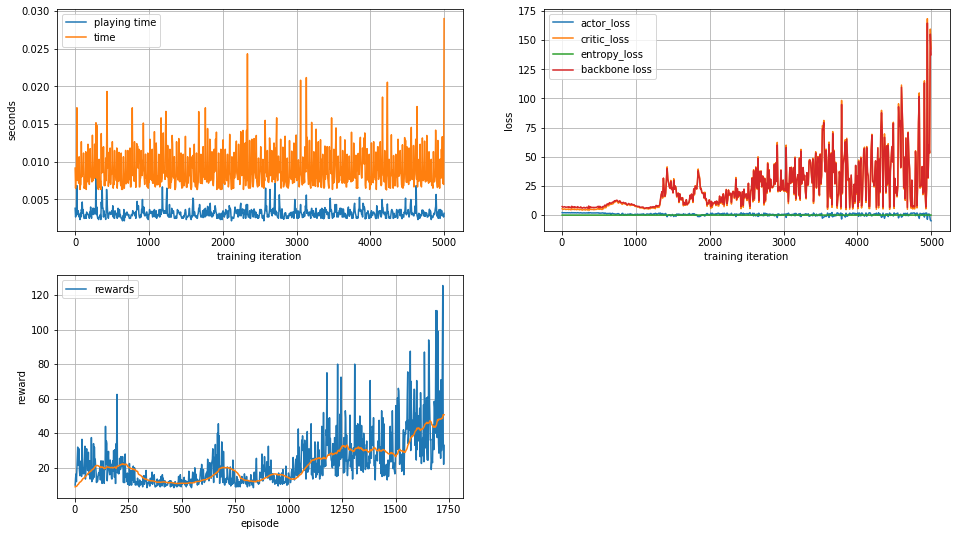

In [7]:
system.run(5000)

In [8]:
agent.runner.fps

896.4939772646027

In [9]:
# rollout collecting...
system.run(4)

In [10]:
# actual optimization step.
system.run(debug=True)

runner: plays one step.
  policy: received act query.
    backbone: forward pass for state computed.
    policy: forward pass for state computed.
trainer: initiates loss computation.
  runner: returns same transitions.
  rollout: rollout generated!
  actor_loss: starts loss calculation.
    maxtrace: starts computing max trace returns
      backbone: forward pass for last state computed.
      critic: forward pass for last state computed.
    backbone: reused output for state from cache!
    critic: forward pass for state computed.
    policy: reused output for state from cache!
  actor_loss: finished loss calculation.
  rollout: returns same sample.
  critic_loss: starts loss calculation.
    critic: reused output for state from cache!
    maxtrace: starts computing max trace returns
      critic: reused output for last state from cache!
  critic_loss: finished loss calculation.
  rollout: returns same sample.
  entropy_loss: starts loss calculation.
    policy: reused output for stat

# QAC

Actor-Critic where critic is trained via Q-learning. Yep.

In [11]:
DQN = lambda runner: Composed(
    replay          = ReplayBuffer(runner=runner),
    sampler         = Sampler(replay="replay"),
    backbone        = Backbone(CartpoleNN()),
    q_head          = QualityHead(backbone="backbone"),
    target          = Target(evaluator="frozen_head"),
    loss            = CriticLoss(sampler="sampler", critic="q_head", target="target"),
    frozen_backbone = Frozen(Backbone)(source="backbone"),
    frozen_head     = Frozen(QualityHead)(backbone="frozen_backbone", source="q_head"),
    trainer         = Trainer(backbone="backbone", losses=["loss"]),
)

In [12]:
A2C = lambda runner, critic: Composed(
    rollout      = RolloutCollector(runner=runner, rollout_length=5),
    backbone     = Backbone(CartpoleNN()),
    policy       = PolicyHead(backbone="backbone"),
    maxtrace     = MaxTrace(evaluator=critic),
    actor_loss   = ActorLoss(rollout="rollout", policy="policy", target="maxtrace", baseline=critic),
    entropy_loss = EntropyLoss(rollout="rollout", policy="policy"),
    trainer      = Trainer(backbone="backbone", losses=["actor_loss", "entropy_loss"], weights=[1, 0.1])
)

In [13]:
agent = Composed(
    visualizer = Visualizer(),
    runner     = Runner(policy="A2C.policy", threads=8),
    A2C        = A2C(runner="runner", critic="DQN.q_head"),
    DQN        = DQN(runner="runner"),
    a2c_player = Player(policy="A2C.policy", timer=100),
    dqn_player = Player(policy="DQN.q_head", timer=100),
)

In [14]:
system = System(agent, make_env=make_env)

runner: environment initialization... Finished.
Adding new head <A2C.policy> to <A2C.backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([2])
Adding new head <DQN.q_head> to <DQN.backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([2])


In [15]:
agent

<visualizer>: Plots logs every 100 iteration
<runner>: Makes one step in 8 parallel environments each 1 iteration using <A2C.policy>
<A2C>:
    <rollout>: Collects rollouts of length 5 from <runner>
    <backbone>: Backbone of network
    <policy>: Head, connected to <A2C.backbone>, modeling Policy
    <maxtrace>: Estimates maxtrace returns using <DQN.q_head> to evaluate last state
    <actor_loss>: Calculates gradient estimation for <A2C.policy> using returns from <A2C.maxtrace>, baseline from <DQN.q_head> and rollouts from <A2C.rollout>
    <entropy_loss>: Calculates entropy penalty for <A2C.policy> using rollouts from <A2C.rollout>
    <trainer>: Trains <A2C.backbone> with all heads using following losses: <A2C.actor_loss>, <A2C.entropy_loss>
    
<DQN>:
    <replay>: Stores observations from <runner>
    <sampler>: Samples mini-batches from <DQN.replay>
    <backbone>: Backbone of network
    <q_head>: Head, connected to <DQN.backbone>, modeling Quality
    <target>: Calculates one

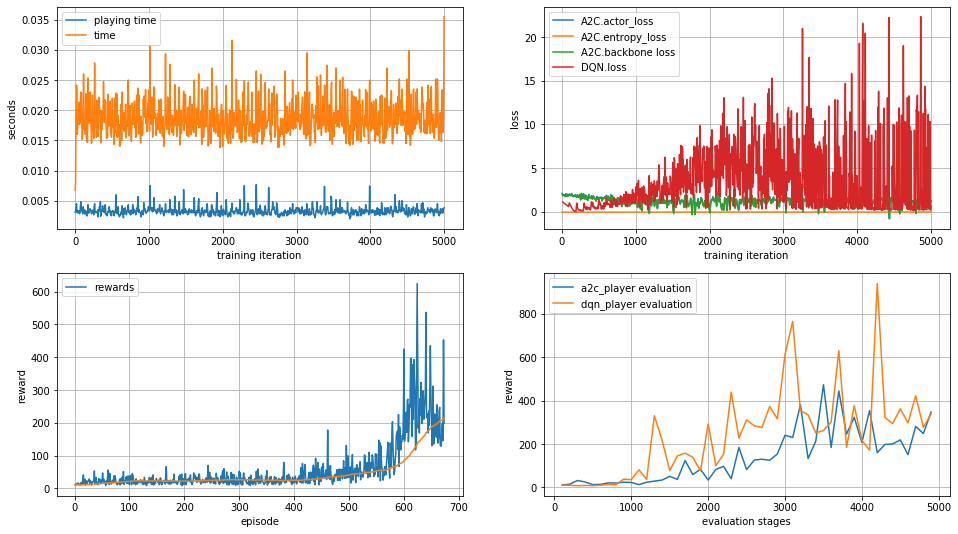

In [16]:
system.run(5000)